### Authors : Filippo Prazzoli, Veronica Finazzi, Alessandro Vitriolo 
### Latest Revision Date: 08/01/2025
### License : GPL v3.0

#### CellOracle Regulatory Regions Preparation

In [2]:
import pandas as pd
import numpy as np
np.random.seed(213)
import sklearn
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import time
from IPython.core.interactiveshell import InteractiveShell
import scanpy as sc
from collections import Counter
from scipy.stats import spearmanr
from itertools import chain

import os
os.chdir('')

import celloracle as co
from celloracle import motif_analysis as ma
from celloracle.utility import save_as_pickled_object
co.__version__
from genomepy import Genome

InteractiveShell.ast_node_interactivity = "all"

import gc
gc.collect()

sc.settings.verbosity = 3          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150, dpi_save = 300, transparent = 'False', color_map = 'viridis')
sns.set_style("darkgrid")#, {"axes.facecolor": "0.93"})
sns.set_palette('YlOrBr')
sns.set_context('talk')

# %matplotlib inline
# This worked
# scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==1.5.3 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.4 louvain==0.8.2 pynndescent==0.5.12

2024-05-13 10:25:53.142670: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 10:26:02.952244: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 10:26:25.514532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==1.5.3 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.4 louvain==0.8.2 pynndescent==0.5.12


In [ ]:
import genomepy
genomepy.install_genome(name="hg19", provider="UCSC")

ref_genome = "hg19"

### Scan

In [4]:
# chr1 start1 end1 chr2 start2 end2 co-access scores pvalues counts ...
# annotate peak1 and peak2 (prom - intron - exon ...)
# whem you have ATAC data, 
    # introns covered ATAC counts
    # if >= 50% reads within intron : distal/enhancer regions
    # if >= 50% shared with exons : splicing junctions

# th 0.6 0.8
# distribution
# 0.4 0.5
# -> functional interactions
# != physical

# keep peaks that are putative regulatory regions co-accessible with known promoters
# GFF : cellRanger -> certain genome reference -> get your promoters from there

peak_df = pd.read_csv("combined_aggregated_results.4Dh1esc.bed", index_col=None,sep='\t').loc[:,['name','gene']]
peak_df.columns = ['peak_id','gene_short_name']
peak_df

,peak_id,gene_short_name
0,chr1_100316130_100316135,AGL
1,chr1_230832630_230834160,AGT
2,chr1_115244990_115245010,AMPD1
3,chr1_201082420_201082440,CACNA1S
4,chr1_236029900_236030690,LYST
...,...,...
483700,chrY_22737401_22739401,EIF1AY
483701,chrY_22747604_22749604,EIF1AY
483702,chrY_58971801_58973801,SPRY3
483703,chrY_58978201_58980201,SPRY3


In [5]:
# check data
def decompose_chrstr(peak_str):
    """
    Args:
        peak_str (str): peak_str. e.g. 'chr1_3094484_3095479'
        
    Returns:
        tuple: chromosome name, start position, end position
    """
    
    *chr_, start, end = peak_str.split("_")
    chr_ = "_".join(chr_)
    return chr_, start, end

from genomepy import Genome

def check_peak_format(peaks_df, ref_genome):
    """
    Check peak format. 
     (1) Check chromosome name. 
     (2) Check peak size (length) and remove short DNA sequences (<5bp)
    
    """
    
    df = peaks_df.copy()
    
    n_peaks_before = df.shape[0]
    
    # Decompose peaks and make df
    decomposed = [decompose_chrstr(peak_str) for peak_str in df["peak_id"]]
    df_decomposed = pd.DataFrame(np.array(decomposed), index=peaks_df.index)
    df_decomposed.columns = ["chr", "start", "end"]
    df_decomposed["start"] = df_decomposed["start"].astype(int)
    df_decomposed["end"] = df_decomposed["end"].astype(int)
    
    # Load genome data
    genome_data = Genome(ref_genome)
    all_chr_list = list(genome_data.keys())
    
    
    # DNA length check
    lengths = np.abs(df_decomposed["end"] - df_decomposed["start"])

    # Filter peaks with invalid chromosome name and small size
    n_threshold = 5
    df = df[(lengths >= n_threshold) & df_decomposed.chr.isin(all_chr_list)]
    
    # DNA length check
    lengths = np.abs(df_decomposed["end"] - df_decomposed["start"])
    
    # Data counting
    n_invalid_length = len(lengths[lengths < n_threshold])
    n_peaks_invalid_chr = n_peaks_before - df_decomposed.chr.isin(all_chr_list).sum()
    n_peaks_after = df.shape[0]
    
    
    #
    print("Peaks before filtering: ", n_peaks_before)
    print("Peaks with invalid chr_name: ", n_peaks_invalid_chr)
    print("Peaks with invalid length: ", n_invalid_length)
    print("Peaks after filtering: ", n_peaks_after)
    
    return df

In [6]:
peak_df = check_peak_format(peak_df, ref_genome)

Peaks before filtering:  483705
Peaks with invalid chr_name:  0
Peaks with invalid length:  0
Peaks after filtering:  483705


In [7]:
decomposed = [decompose_chrstr(peak_str) for peak_str in peak_df["peak_id"]]
df_decomposed = pd.DataFrame(np.array(decomposed), index=peak_df.index)
df_decomposed.columns = ["chr", "start", "end"]
df_decomposed["start"] = df_decomposed["start"].astype(int)
df_decomposed["end"] = df_decomposed["end"].astype(int)

In [8]:
df_decomposed['length'] = df_decomposed.end - df_decomposed.start

In [9]:
sns.histplot(df_decomposed.length, color='darkred', edgecolor = 'darkred', alpha = 0.9, binwidth=30)

<AxesSubplot: xlabel='length', ylabel='Count'>

In [10]:
peak_df_filt = peak_df[(df_decomposed.length > 150) & (df_decomposed.length < 5000)]
peak_df_filt.shape

(228424, 2)

In [11]:
%matplotlib inline

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

([<matplotlib.axis.XTick at 0x15548f163ee0>,
 [Text(0.0, 0, 'Unfiltered'), Text(0.15, 0, 'Filtered')])

Text(0.5, 0, 'Data')

Text(0, 0.5, 'Number of peaks')

(array([     0., 100000., 200000., 300000., 400000., 500000., 600000.]),
 [Text(0, 0.0, '0'),
  Text(0, 100000.0, '100000'),
  Text(0, 200000.0, '200000'),
  Text(0, 300000.0, '300000'),
  Text(0, 400000.0, '400000'),
  Text(0, 500000.0, '500000'),
  Text(0, 600000.0, '600000')])

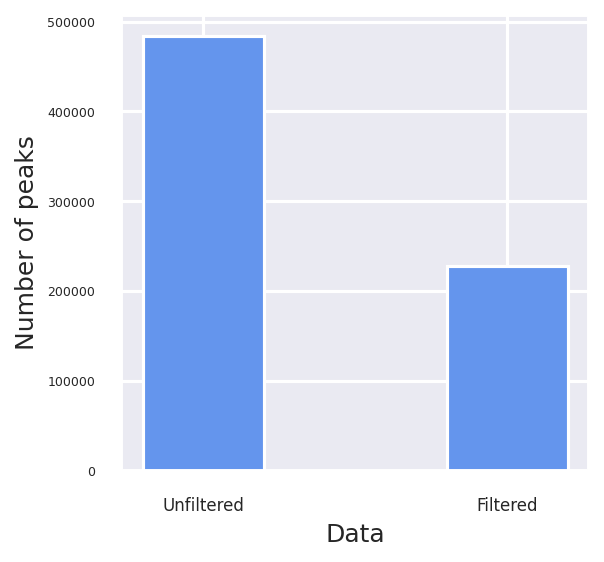

In [30]:
len_unfilt = len(peak_df)
len_filt = len(peak_df_filt)

x = ['Unfiltered', 'Filtered']
position_bars = range(len(x))

bar_width = 0.06

plt.bar(0, len_unfilt, width=bar_width, color='cornflowerblue')
plt.bar(0.15, len_filt, width=bar_width, color='cornflowerblue')

plt.xticks([0, 0.15], x, fontsize=8)


plt.xlabel('Data', fontsize=12)
plt.ylabel('Number of peaks', fontsize=12)

plt.yticks(fontsize=6)

plt.show()

In [12]:
peak_df_filt.to_csv("PeakDF2Celloracle.bed", index = False)

In [38]:
peak_df_filt = pd.read_csv("PeakDF2Celloracle.bed")

In [10]:
peak_df_filt

,peak_id,gene_short_name
1,chr1_230832630_230834160,AGT
4,chr1_236029900_236030690,LYST
9,chr1_169555430_169556305,F5
11,chr1_24194620_24195030,FUCA1
14,chr1_24151595_24152015,HMGCL
...,...,...
483700,chrY_22737401_22739401,EIF1AY
483701,chrY_22747604_22749604,EIF1AY
483702,chrY_58971801_58973801,SPRY3
483703,chrY_58978201_58980201,SPRY3


In [11]:
tfi = ma.TFinfo(peak_data_frame=peak_df_filt, 
                ref_genome=ref_genome) 


# Scan motifs. !!CAUTION!! This step may take several hours if you have many peaks!
          #TF1 #TF2 #TF3 ...
#peak1     0.00
#peak2     0.1
#peak3     1 
#...

# 
tfi.scan(fpr=0.02, 
         motifs=None,  # default motifs will be loaded. For human: gimme.vertebrate.v5.0. https://gimmemotifs.readthedocs.io/en/master/overview.html 
         verbose=True)
# --motifs None
# --thread
# Save tfinfo object

# Check motif scan results
tfi.scanned_df.head()

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 



2024-05-06 10:37:34,392 - DEBUG - using background: genome hg19 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



Scanning:   0%|          | 0/173547 [00:00<?, ? sequences/s]

,seqname,motif_id,factors_direct,factors_indirect,score,pos,strand
0,chr10_100027007_100029007,GM.5.0.Mixed.0001,,"SRF, EGR1",8.491542,1154,1
1,chr10_100027007_100029007,GM.5.0.Mixed.0001,,"SRF, EGR1",8.369501,1549,-1
2,chr10_100027007_100029007,GM.5.0.Mixed.0001,,"SRF, EGR1",8.280041,1550,-1
3,chr10_100027007_100029007,GM.5.0.Mixed.0001,,"SRF, EGR1",8.280041,1551,-1
4,chr10_100027007_100029007,GM.5.0.Mixed.0001,,"SRF, EGR1",8.280041,1552,-1


In [13]:
tfi.to_hdf5(file_path="20240124_tfi.celloracle.tfinfo")

In [14]:
# Reset filtering 
tfi.reset_filtering()

# Do filtering
tfi.filter_motifs_by_score(threshold=10)

# Format post-filtering results.
tfi.make_TFinfo_dataframe_and_dictionary(verbose=True)

df = tfi.to_dataframe()
df.head()
df.to_parquet("20240124_tfi.celloracle.parquet")

Filtering finished: 105803910 -> 22913834
1. Converting scanned results into one-hot encoded dataframe.


  0%|          | 0/173515 [00:00<?, ?it/s]

2. Converting results into dictionaries.


  0%|          | 0/21595 [00:00<?, ?it/s]

  0%|          | 0/1094 [00:00<?, ?it/s]

,peak_id,gene_short_name,9430076C15RIK,AC002126.6,AC012531.1,AC226150.2,AFP,AHR,AHRR,AIRE,...,ZNF784,ZNF8,ZNF816,ZNF85,ZSCAN10,ZSCAN16,ZSCAN22,ZSCAN26,ZSCAN31,ZSCAN4
0,chr10_100027007_100029007,AVPI1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_100027007_100029007,MORN4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,chr10_100027007_100029007,PI4K2A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr10_100170634_100172634,HPS1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_100170634_100172634,HPSE2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
gc.collect()

20